In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## aisles.csv

*aisles* is a small reference dataset containing the aisle id and description:

In [2]:
ais = pd.read_csv('./data/aisles.csv')
ais.shape

(134, 2)

In [3]:
ais.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


## departments.csv

*departments* is a small reference dataset containing the department id and description:

In [4]:
dpts = pd.read_csv('./data/departments.csv')
dpts.shape

(21, 2)

In [5]:
dpts.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


These are the different options for *department*.

In [6]:
dpts['department'].unique()

array(['frozen', 'other', 'bakery', 'produce', 'alcohol', 'international',
       'beverages', 'pets', 'dry goods pasta', 'bulk', 'personal care',
       'meat seafood', 'pantry', 'breakfast', 'canned goods', 'dairy eggs',
       'household', 'babies', 'snacks', 'deli', 'missing'], dtype=object)

## products.csv

*products* is a ~50k record dataset of all the different products sold on the website. The *products* dataset contains the aisle and department id, so we want to merge the values from those datasets into *products*.

In [7]:
prod_basic = pd.read_csv('./data/products.csv')
prod_basic.shape

(49688, 4)

In [8]:
prod_basic.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


*aisle* and *department* data is merged into the *products* dataset:

In [9]:
prod_full = pd.merge(prod_basic, ais, how='left', left_on='aisle_id', right_on='aisle_id')
prod_full = pd.merge(prod_full, dpts, \
                            how='left', left_on='department_id', right_on='department_id')
prod_full.head()

,product_id,product_name,aisle_id,department_id,aisle,department
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
1,2,All-Seasons Salt,104,13,spices seasonings,pantry
2,3,Robust Golden Unsweetened Oolong Tea,94,7,tea,beverages
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen meals,frozen
4,5,Green Chile Anytime Sauce,5,13,marinades meat preparation,pantry


We might also want to understand the number of products in each aisle. Interestingly we find the the largest grouping for aisle is actually *missing values*, so we may need to account for this later when building a model.

In [10]:
prod_grp = prod_full['product_name'].groupby(prod_full['aisle']).count()
prod_grp.sort_values(ascending=False).head()

aisle
missing                 1258
candy chocolate         1246
ice cream ice           1091
vitamins supplements    1038
yogurt                  1026
Name: product_name, dtype: int64

We can also look at the number of aisles in each department.

In [11]:
# Group the full dataframe by department & aisle.
ais_grp = prod_full.groupby(['department','aisle']).size().reset_index().rename(columns={0:'count'})
# Group the grouped dataframe by department to get aisle count.
dep_grp = ais_grp['aisle'].groupby(ais_grp['department']).count()
dep_grp

department
alcohol             5
babies              4
bakery              5
beverages           8
breakfast           4
bulk                2
canned goods        5
dairy eggs         10
deli                5
dry goods pasta     5
frozen             11
household          10
international       4
meat seafood        7
missing             1
other               1
pantry             12
personal care      17
pets                2
produce             5
snacks             11
Name: aisle, dtype: int64

## order_products__prior.csv

*order_products__prior* is a large dataset containing previous order history, with the order id, product id, order in which it was added to the cart, and whether the item was a reorder or not (which is our target variable).

In [12]:
opp = pd.read_csv('./data/order_products__prior.csv')
opp.shape

(32434489, 4)

In [13]:
opp.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


We can add in the product, department, and aisle names:

In [14]:
opp_full = pd.merge(opp, prod_full, how='left', left_on='product_id', right_on='product_id')
opp_full.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry


We can demonstrate that *add_to_cart_order* just gives the numbering of the order in which products were added to each order, and may be of no predictive value for this problem.

In [16]:
# Add a column to count the number of products in each order.
opp_full['product_count'] = opp_full.groupby('order_id')['order_id'].transform('count')

# Now add a column to find the maximum 'add_to_cart_order' order for each order.
opp_full['add_to_cart_max'] = opp_full.groupby('order_id')['add_to_cart_order'].transform('max')

# If our assumption is correct then the values in the 2 new columns should always match.
# Add a column to check if these values match.
opp_full['match'] = np.where(opp_full['product_count']==opp_full['add_to_cart_max'],
                                          True, False)
opp_full.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,product_count,add_to_cart_max,match
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,9,9,True
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce,9,9,True
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry,9,9,True
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry,9,9,True
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry,9,9,True


In [17]:
# Now check to see if all match values are True.
opp_full['match'].unique()

array([ True], dtype=bool)

##### Confirmed!
*add_to_cart_order* is just a count of the items in each order, so is probably not required for this analysis.

We can now use the *product_count* feature we just created look at the distribution of number of products per order. We see that most orders contain below 20 products:

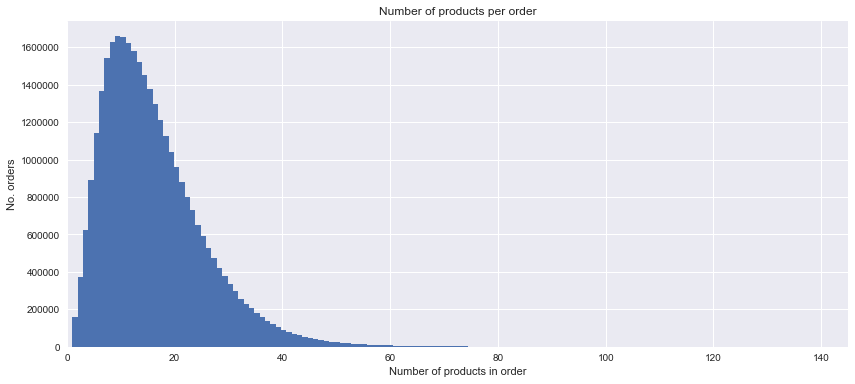

In [18]:
number_bins = opp_full['product_count'].max()
plt.figure(num=1,figsize=(14,6))
plt.hist(opp_full['product_count'], bins=number_bins)
plt.xlabel('Number of products in order')
plt.ylabel('No. orders')
plt.title('Number of products per order')
plt.ticklabel_format(style='plain')
plt.xlim(0,number_bins)
plt.show()

And for each product we can calculate its propensity to be reorded, as the sum of the *reordered* column for each product (because the reorder values are either 0 for False or 1 for True), divided by the total number of times the product was ordered.

In [19]:
# Groupby to calculate the number of times each product_id appears in the df
numberBought = opp_full['product_id'].groupby(opp_full['product_id']).count()

# Groupby to sum the values in the reorded column for each product_id (since 1 = True) 
reorders = opp_full['reordered'].groupby(opp_full['product_id']).sum()

# Combine into 1 dataframe
product_df = pd.concat([numberBought, reorders], axis=1)

# Calculate reorder_rate as the reorder total divided by total number of orders
product_df['reorder_rate'] = product_df['reordered'] / product_df['product_id']

# Rename columns
product_df.rename(columns={'product_id':'number_bought',\
                           'reordered':'total_reorders'}, inplace=True)

# Sort by reorder rate then by number of orders, highest to lowest
product_df.sort_values(by=['reorder_rate','number_bought'], axis=0, ascending=False, inplace=True)

# Make product_id into a column
product_df.reset_index(inplace=True)

# Merge in product name info.
product_df = pd.merge(product_df, prod_full[['product_id','aisle','department','product_name']], \
                      how='left', left_on='product_id', right_on='product_id')

product_df.head()

,product_id,number_bought,total_reorders,reorder_rate,aisle,department,product_name
0,6433,68,64,0.941176,prepared meals,deli,Raw Veggie Wrappers
1,2075,87,81,0.931034,feminine care,personal care,Serenity Ultimate Extrema Overnight Pads
2,43553,13,12,0.923077,energy sports drinks,beverages,Orange Energy Shots
3,27740,101,93,0.920792,candy chocolate,snacks,Chocolate Love Bar
4,14609,35,32,0.914286,baby food formula,babies,Soy Powder Infant Formula


In [20]:
product_df.tail()

,product_id,number_bought,total_reorders,reorder_rate,aisle,department,product_name
49672,48151,1,0,0.0,missing,missing,Grill Mates Brown Sugar Bourbon Seasoning
49673,48211,1,0,0.0,instant foods,dry goods pasta,Cajun Sides Dirty Rice
49674,48343,1,0,0.0,beers coolers,alcohol,Hennepin Farmhouse Ale
49675,48461,1,0,0.0,ice cream toppings,snacks,The Ultimate Caramel Suace
49676,49487,1,0,0.0,dog food care,pets,Vitality Chicken Breasts with Flaxseed & Vitam...


We can plot the *reorder_rate* for all the products, and we see that there is a large group of products with no reorders.

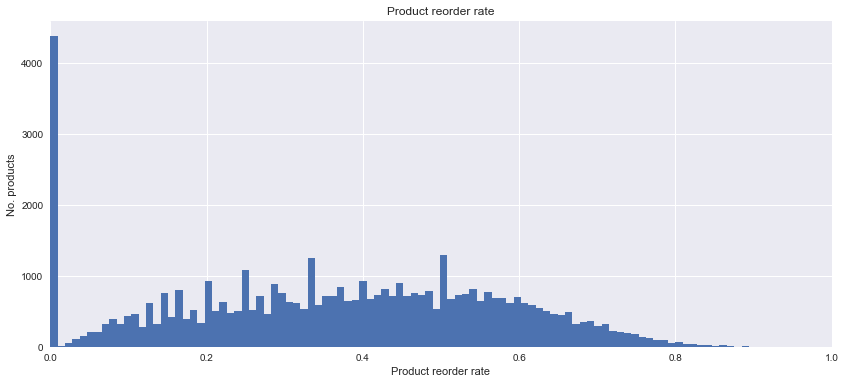

In [21]:
# Plot the reorded rate as a histogram
plt.figure(num=2,figsize=(14,6))
plt.hist(product_df['reorder_rate'],bins=100)
plt.xlabel('Product reorder rate')
plt.ylabel('No. products')
plt.title('Product reorder rate')
plt.ticklabel_format(style='plain')
plt.xlim(0,1)
plt.show()

Products have sold an average of 653 times:

In [22]:
product_df['number_bought'].mean()

652.90756285605005

The most poular product is bananas, selling 473k times:

In [23]:
product_df[product_df['number_bought']==product_df['number_bought'].max()]

,product_id,number_bought,total_reorders,reorder_rate,aisle,department,product_name
72,24852,472565,398609,0.843501,fresh fruits,produce,Banana


131 different products have only sold once:

In [24]:
product_df[product_df['number_bought']==1]['number_bought'].count()

131

Let's see if there is an obvious correlation between how well a product sells and how often it is reordered, which seems like a logical assumption. We'll also colour code the data points by *department*, to see if any obvious patterns emerge, and we see that the products with the highest numbers bought are mostly in the *fresh produce* department.

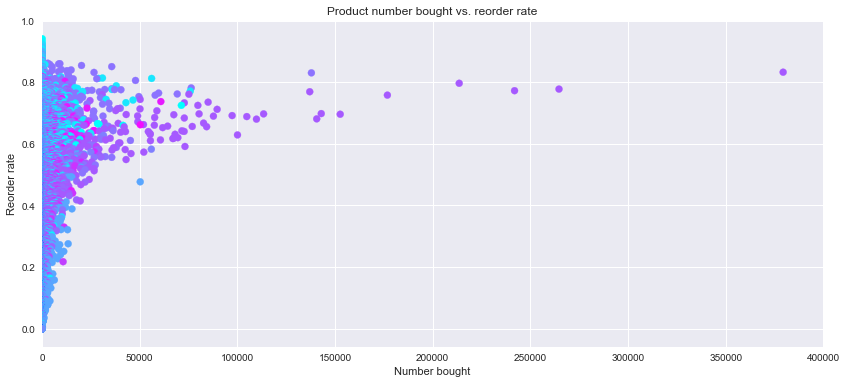

In [25]:
# Create colour field in dataframe, with integers representing each department.

# Create colour mapping
depts = product_df['department'].unique()
colours = {}
for dept in range(len(depts)):
    colours[depts[dept]]=dept

# Apply colour mapping to dataframe
product_df['colour'] = 0
for row in range(len(product_df)):
    product_df.loc[row, 'colour']=colours[product_df.loc[row, 'department']]

# Plot the number sold against the reorder rate, as a scatter plot.
plt.figure(num=3,figsize=(14,6))
plt.scatter(x=product_df['number_bought'], y=product_df['reorder_rate'], c=product_df['colour'], cmap=plt.cm.cool)
plt.xlabel('Number bought')
plt.ylabel('Reorder rate')
plt.title('Product number bought vs. reorder rate')
plt.ticklabel_format(style='plain')
plt.xlim(0,400000)
plt.show()

It does appear that there is a slight linear relationship between the reorder rate and number bought. Let's shorten the x-axis to get a better picture, excluding the high-selling outliers. Knowing that products sell an average of 653 times, we'll limit the x-axis to 1000.

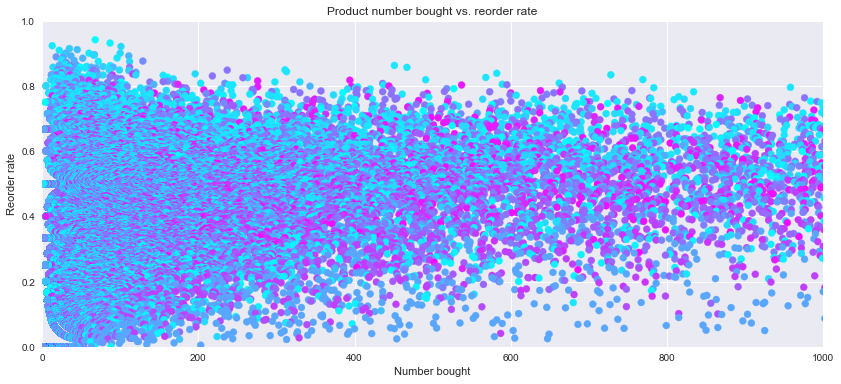

In [26]:
# Create the scatter plot
plt.figure(num=4,figsize=(14,6))
plt.scatter(x=product_df['number_bought'], y=product_df['reorder_rate'], c=product_df['colour'], cmap=plt.cm.cool)
plt.xlabel('Number bought')
plt.ylabel('Reorder rate')
plt.title('Product number bought vs. reorder rate')
plt.ticklabel_format(style='plain')
plt.xlim(0,1000) # Limiting x-axis to 1000 now
plt.ylim(0,1)
plt.show()

In [27]:
print len(opp_full['order_id'].unique()), 'unique orders.'

3214874 unique orders.


In [28]:
print 'Average',round(float(len(opp_full)) / len(opp_full['order_id'].unique()),2) , 'products per order.'

Average 10.09 products per order.


## order_products__train.csv

*order_products__train* is another dataset with the same features as *order_products__prior*. We won't run through the same exploration this at this stage, as we will focus on merging all the data together into one dataset to start training models on.

In [29]:
opt = pd.read_csv('./data/order_products__train.csv')
opt.head(2)

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1


In [30]:
opt.shape

(1384617, 4)

In [31]:
print len(opt['order_id'].unique()), 'unique orders.'

131209 unique orders.


## orders.csv

*orders* gives the metadata about each order made, so that there is only one order per row.

In [33]:
orders = pd.read_csv('./data/orders.csv')
orders.shape

(3421083, 7)

In [34]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


Let's see when during the day most orders are made.

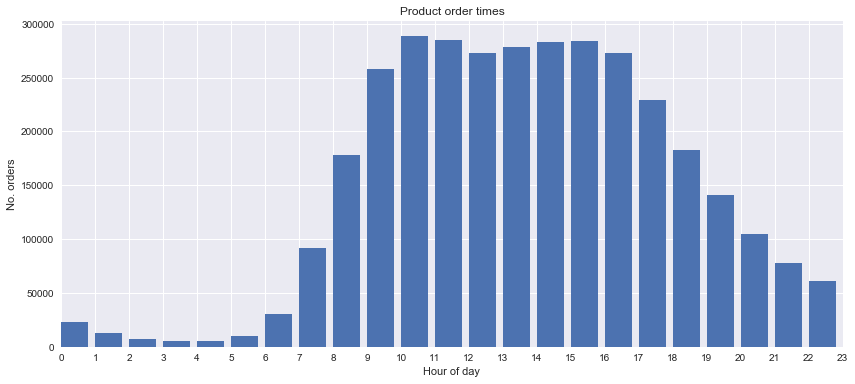

In [35]:
# Create pivot table
hod_count = pd.pivot_table(orders, values = 'order_id', index='order_hour_of_day',\
                          aggfunc='count')

# Plot the order hour of day
plt.figure(num=5,figsize=(14,6))
plt.bar(left=hod_count.index, height=hod_count['order_id'], data=hod_count, align='edge')
plt.xticks(range(24))
plt.xlim(0,23)
plt.xlabel('Hour of day')
plt.ylabel('No. orders')
plt.title('Product order times')
plt.ticklabel_format(style='plain')
plt.show()

And the same for day of week.

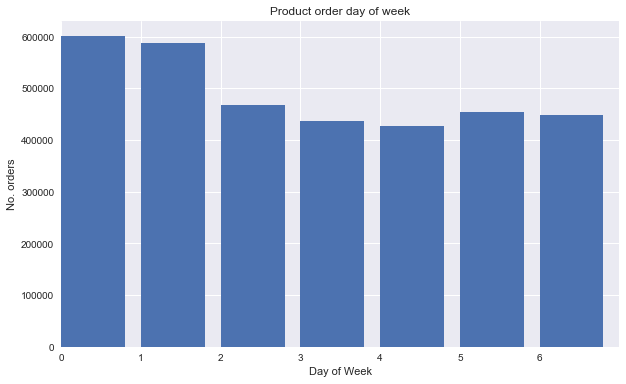

In [37]:
# Create pivot table
dow_count = pd.pivot_table(orders, values = 'order_id', index='order_dow',\
                          aggfunc='count')

# Plot the order hour of day
plt.figure(num=6,figsize=(10,6))
plt.bar(left=dow_count.index, height=dow_count['order_id'], data=dow_count, align='edge')
plt.xticks(range(7))
plt.xlim(0,7)
plt.xlabel('Day of Week')
plt.ylabel('No. orders')
plt.title('Product order day of week')
plt.ticklabel_format(style='plain')
plt.show()

With the *eval_set* feature, we should expect that the number of orders with *eval_set = prior* should be equal to the number of unique orders in the *prior* data set; and similarly for the *order_products__train* dataset:

In [38]:
print 'counts from the orders dataset:\n',orders['eval_set'].groupby(orders['eval_set']).count()
print '\nprior orders:',len(opp_full['order_id'].unique())
print '\ntrain orders:',len(opt['order_id'].unique())

counts from the orders dataset:
eval_set
prior    3214874
test       75000
train     131209
Name: eval_set, dtype: int64

prior orders: 3214874

train orders: 131209


We can therefore join the datasets *order_products__train*, *order_products__prior*, and merge them with *orders* to get the metadata (as well as *aisles* and *departments*).

## big merged dataset

First we'll join each of *order_products__train* and *order_products__prior* with the *orders* dataset to add in the order metadata. Then we'll join the 2 datasets into one and add in the *aisle* and *department* labels.

In [39]:
opp_orders = pd.merge(opp, orders, how='left', left_on='order_id', right_on='order_id')
opp_orders.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,202279,prior,3,5,9,8.0
1,2,28985,2,1,202279,prior,3,5,9,8.0
2,2,9327,3,0,202279,prior,3,5,9,8.0
3,2,45918,4,1,202279,prior,3,5,9,8.0
4,2,30035,5,0,202279,prior,3,5,9,8.0


In [40]:
opp_orders.shape

(32434489, 10)

In [41]:
# Confirm no data lost:
len(opp_orders) == len(opp)

True

In [42]:
opt_orders = pd.merge(opt, orders, how='left', left_on='order_id', right_on='order_id')
opt_orders.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1,49302,1,1,112108,train,4,4,10,9.0
1,1,11109,2,1,112108,train,4,4,10,9.0
2,1,10246,3,0,112108,train,4,4,10,9.0
3,1,49683,4,0,112108,train,4,4,10,9.0
4,1,43633,5,1,112108,train,4,4,10,9.0


In [43]:
opt_orders.shape

(1384617, 10)

In [44]:
# Confirm no data lost:
len(opt_orders) == len(opt)

True

In [45]:
opp_opt_orders = opp_orders.append(opt_orders, ignore_index=True)
opp_opt_orders.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,202279,prior,3,5,9,8.0
1,2,28985,2,1,202279,prior,3,5,9,8.0
2,2,9327,3,0,202279,prior,3,5,9,8.0
3,2,45918,4,1,202279,prior,3,5,9,8.0
4,2,30035,5,0,202279,prior,3,5,9,8.0


In [46]:
opp_opt_orders.shape

(33819106, 10)

In [47]:
# Confirm no data lost:
len(opp_opt_orders) == len(opt_orders)+len(opp_orders)

True

In [48]:
# Merge in rest of product info from *product_df* dataset created earlier.
df = pd.merge(opp_opt_orders, product_df, how='left', left_on='product_id', right_on='product_id')
df.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,number_bought,total_reorders,reorder_rate,aisle,department,product_name,colour
0,2,33120,1,1,202279,prior,3,5,9,8.0,19400.0,13744.0,0.708454,eggs,dairy eggs,Organic Egg Whites,11.0
1,2,28985,2,1,202279,prior,3,5,9,8.0,67449.0,46841.0,0.694465,fresh vegetables,produce,Michigan Organic Kale,13.0
2,2,9327,3,0,202279,prior,3,5,9,8.0,6299.0,995.0,0.157962,spices seasonings,pantry,Garlic Powder,7.0
3,2,45918,4,1,202279,prior,3,5,9,8.0,744.0,203.0,0.272849,oils vinegars,pantry,Coconut Butter,7.0
4,2,30035,5,0,202279,prior,3,5,9,8.0,569.0,289.0,0.507909,baking ingredients,pantry,Natural Sweetener,7.0


In [50]:
df.shape

(33819106, 17)

We can now visualise details about the products in relation to the order metadata, for example the times of day that products from different departments are ordered:

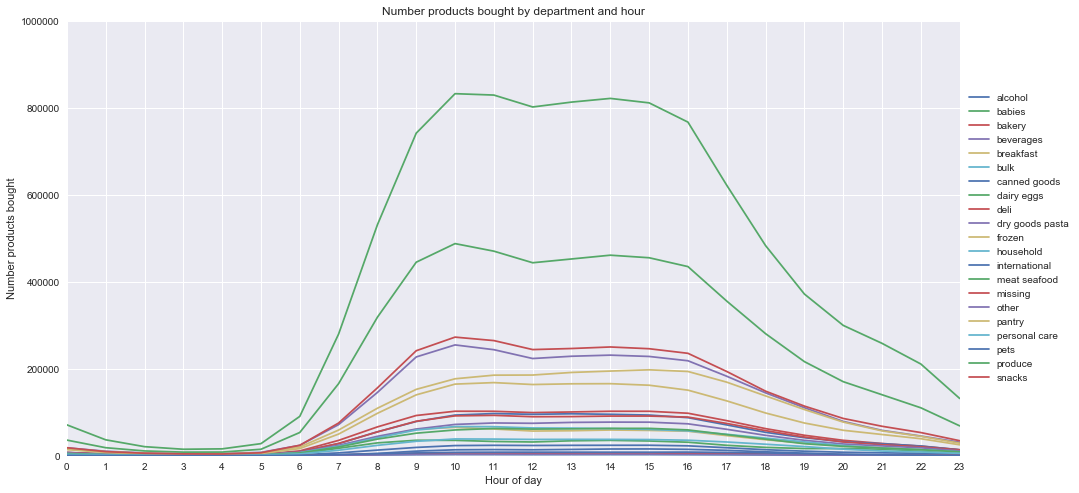

In [51]:
# This gives the pivot table counting orders at each hour of the day for each department
hod_dept = pd.pivot_table(data=df, values='product_id', index='order_hour_of_day',\
               columns='department', aggfunc='count')

# Create the line plot
plt.figure(num=7,figsize=(16,8))
plt.plot(hod_dept)
plt.legend(hod_dept.columns,loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Hour of day')
plt.ylabel('Number products bought')
plt.title('Number products bought by department and hour')
plt.xticks(range(24))
plt.xlim(0,23)
plt.ylim(0,1000000)
plt.show()

This is fairly useful, as it gives an idea of the differences in volumes of orders for each department, but we also want to look at the orders per hour as a percentage of the total orders for each department, to be able to see differences in 

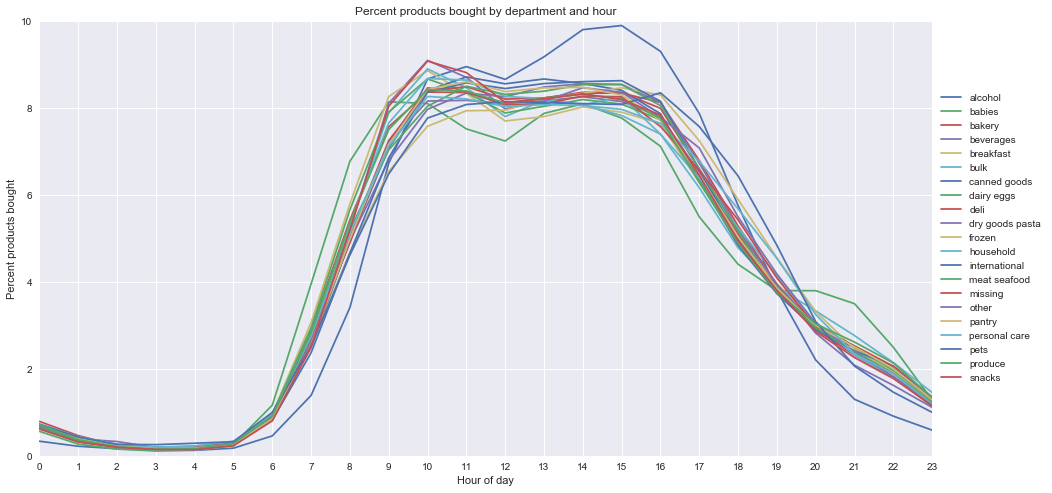

In [52]:
# Convert totals into percentages 
hod_dept_pc = pd.DataFrame()
for column in hod_dept.columns:
    hod_dept_pc[column] = (hod_dept[column] / hod_dept[column].sum() * 100).astype(float)

# Create the line plot
plt.figure(num=8,figsize=(16,8))
plt.plot(hod_dept_pc)
plt.legend(hod_dept_pc.columns, loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Hour of day')
plt.ylabel('Percent products bought')
plt.title('Percent products bought by department and hour')
plt.xticks(range(24))
plt.xlim(0,23)
plt.ylim(0,10)
plt.show()

We can look at how the reorder rate varies with the number of days since the previous order was made. There are distinct peaks in multiples of seven days (i.e. reordering after 1 week, 2 weeks, etc.)

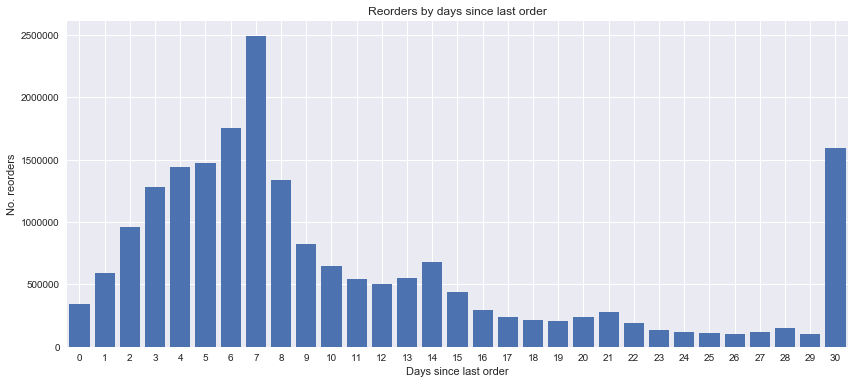

In [53]:
days_grp = df['reordered'].groupby(df['days_since_prior_order']).sum()

# Plot the order hour of day
plt.figure(num=9,figsize=(14,6))
plt.bar(left=days_grp.index, height=days_grp.values, \
        data=days_grp, align='center')
plt.xticks(range(int(max(df['days_since_prior_order']))+1))
plt.xlim(-.5,int(max(df['days_since_prior_order']))+.5)
plt.xlabel('Days since last order')
plt.ylabel('No. reorders')
plt.title('Reorders by days since last order')
plt.ticklabel_format(style='plain')
plt.show()

We assume that the large peak at 30 encompasses all reorders made 30 *or more* days after the original order.

We will want to use all the data in the big dataset to train our models, so we will save the *df* dataframe to CSV so it can be used for model building:

In [56]:
df.to_csv('./data/train.csv')

## sample_submission.csv

*sample_submission* is the sample submission dataset for the 75000 orders which are in the *orders* dataset with *eval_set = test*.

In [54]:
sample_submission = pd.read_csv('./data/sample_submission.csv')
sample_submission.shape

(75000, 2)

In [55]:
sample_submission.head()

,order_id,products
0,17,39276 29259
1,34,39276 29259
2,137,39276 29259
3,182,39276 29259
4,257,39276 29259
